<h1>Business Understanding

Microsoft would like recommendations for entering the movie industry. After analyzing the data we would like to provide suggestions that will answer the following questions:  

• What are the most profitable movie genres?  
• What are the top studios based on profit within those genres?  
• What spend levels appear to indicate the best possibility of showing a profit, and how much should Microsoft expect to spend on a typical project?

---

<h1>Data Understanding

The datasets used for analysis came from the following sources:  
• IMDB  
• Box Office Mojo  
• The Numbers 

The analysis centered around the following data for movie release years from 2010 through 2019:  
• Genre  
• Worldwide Profit  
• Studio  
• Production Budget

---

<h1>Data Preparation

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Define the filepaths for all stored data in the Data directory in order to read into dfs
zipped = !ls ./Data/
path = "./Data/"
zipped_files = [path+x for x in zipped]
zipped_files

['./Data/bom.movie_gross.csv.gz',
 './Data/imdb.name.basics.csv.gz',
 './Data/imdb.title.akas.csv.gz',
 './Data/imdb.title.basics.csv.gz',
 './Data/imdb.title.crew.csv.gz',
 './Data/imdb.title.principals.csv.gz',
 './Data/imdb.title.ratings.csv.gz',
 './Data/rt.movie_info.tsv.gz',
 './Data/rt.reviews.tsv.gz',
 './Data/tmdb.movies.csv.gz',
 './Data/tn.movie_budgets.csv.gz']

In [4]:
#Function to read in named dict of dfs
def read_all(namelist):
    """Read contents of zippedData into a named dictionary with names of
    files as keys, dataframes as values.
    
    Takes a list of full filepaths.
    """
    name_dict = {}
    for filename in namelist:
        #extract the portion of the filename corresponding to the "name"
        name = filename[7:-7]
        if filename.endswith('csv.gz'):
            tmp_df = pd.read_csv(filename)
            name_dict[name] = tmp_df
        elif filename.endswith('tsv.gz'):
        #both tsv are encoded in ascii per cmd line and chardet, but for some reason 'latin' appears to do the trick:
            tmp_df = pd.read_csv(filename, sep='\t', encoding='latin')
            name_dict[name] = tmp_df
        #in case there are any additional files in the dir
        else:
            continue
    return name_dict

In [6]:
#Make the dictionary of dataframes and name the keys
df_dict = read_all(zipped_files)
print(df_dict.keys())

dict_keys(['bom.movie_gross', 'imdb.name.basics', 'imdb.title.akas', 'imdb.title.basics', 'imdb.title.crew', 'imdb.title.principals', 'imdb.title.ratings', 'rt.movie_info', 'rt.reviews', 'tmdb.movies', 'tn.movie_budgets'])


In [7]:
# Will be working primarily with the tn_movie_budgets and imdb_title_basics data
df_imdb_title_basics = df_dict['imdb.title.basics']
df_tn_movie_budgets = df_dict['tn.movie_budgets']

In [7]:
# split the genres column up into a list. For easier joining, do not explode until after joined,
# retain original genre column to show the combinations if useful later

df_imdb_title_basics['genre_list'] = df_imdb_title_basics['genres'].str.split(",")
print(df_imdb_title_basics.dtypes)
df_imdb_title_basics.head()

tconst              object
primary_title       object
original_title      object
start_year           int64
runtime_minutes    float64
genres              object
genre_list          object
dtype: object


,tconst,primary_title,original_title,start_year,runtime_minutes,genres,genre_list
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama","[Action, Crime, Drama]"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama","[Biography, Drama]"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,[Drama]
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama","[Comedy, Drama]"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy","[Comedy, Drama, Fantasy]"


In [8]:
df_tn_movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [9]:
# Cleaning the tn_movie_budgets dataframe

# Modify the budget and gross columns to be numeric
df_tn_movie_budgets['production_budget'] = df_tn_movie_budgets['production_budget'] \
                                            .map(lambda x: x.strip('$').replace(',','')).astype(float)
df_tn_movie_budgets['domestic_gross'] = df_tn_movie_budgets['domestic_gross'] \
                                            .map(lambda x: x.strip('$').replace(',','')).astype(float)
df_tn_movie_budgets['worldwide_gross'] = df_tn_movie_budgets['worldwide_gross'] \
                                            .map(lambda x: x.strip('$').replace(',','')).astype(float)

# Create a Year column to help join with other dfs in case of movie title duplicates
df_tn_movie_budgets['year'] = df_tn_movie_budgets['release_date'] \
                                .map(lambda x: int(x[-4:]))

# Define Domestic and Worldwide profit columns as gross - production_budget
df_tn_movie_budgets['domestic_profit'] = df_tn_movie_budgets['domestic_gross'] \
                                        - df_tn_movie_budgets['production_budget']
df_tn_movie_budgets['worldwide_profit'] = df_tn_movie_budgets['worldwide_gross'] \
                                        - df_tn_movie_budgets['production_budget']
df_tn_movie_budgets['domestic_roi'] = df_tn_movie_budgets['domestic_gross'] \
                                        / df_tn_movie_budgets['production_budget']
df_tn_movie_budgets['worldwide_roi'] = df_tn_movie_budgets['worldwide_gross'] \
                                        / df_tn_movie_budgets['production_budget']
df_tn_movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,domestic_profit,worldwide_profit,domestic_roi,worldwide_roi
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,2009,335507625.0,2.351345e+09,1.789430,6.532577
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,-169536125.0,6.350639e+08,0.587101,2.546673
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019,-307237650.0,-2.002376e+08,0.122178,0.427892
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,128405868.0,1.072414e+09,1.388403,4.243841
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,2017,303181382.0,9.997217e+08,1.956408,4.153696


In [10]:
budget_by_genre = df_tn_movie_budgets.merge(df_imdb_title_basics, left_on=['movie', 'year'], right_on=['primary_title', 'start_year'])
budget_by_genre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1547 entries, 0 to 1546
Data columns (total 18 columns):
id                   1547 non-null int64
release_date         1547 non-null object
movie                1547 non-null object
production_budget    1547 non-null float64
domestic_gross       1547 non-null float64
worldwide_gross      1547 non-null float64
year                 1547 non-null int64
domestic_profit      1547 non-null float64
worldwide_profit     1547 non-null float64
domestic_roi         1547 non-null float64
worldwide_roi        1547 non-null float64
tconst               1547 non-null object
primary_title        1547 non-null object
original_title       1547 non-null object
start_year           1547 non-null int64
runtime_minutes      1521 non-null float64
genres               1541 non-null object
genre_list           1541 non-null object
dtypes: float64(8), int64(3), object(7)
memory usage: 229.6+ KB


In [11]:
# This adds the studio to the dataset
df_bom_movie_gross = df_dict['bom.movie_gross']
df_bom_movie_gross.drop(columns = ['domestic_gross', 'foreign_gross'], inplace = True)
df_budget_genre_studio = budget_by_genre \
    .merge(df_bom_movie_gross, left_on=['movie', 'year'], right_on=['title', 'year'])
df_budget_genre_studio.tail()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,domestic_profit,worldwide_profit,domestic_roi,worldwide_roi,tconst,primary_title,original_title,start_year,runtime_minutes,genres,genre_list,title,studio
1047,84,"Aug 2, 2013",The Canyons,250000.0,59671.0,62375.0,2013,-190329.0,-187625.0,0.238684,0.24950,tt2292959,The Canyons,The Canyons,2013,99.0,"Drama,Thriller","[Drama, Thriller]",The Canyons,IFC
1048,48,"Jul 22, 2011",Another Earth,175000.0,1321194.0,2102779.0,2011,1146194.0,1927779.0,7.549680,12.01588,tt1549572,Another Earth,Another Earth,2011,92.0,"Drama,Romance,Sci-Fi","[Drama, Romance, Sci-Fi]",Another Earth,FoxS
1049,80,"Jul 10, 2015",The Gallows,100000.0,22764410.0,41656474.0,2015,22664410.0,41556474.0,227.644100,416.56474,tt2309260,The Gallows,The Gallows,2015,81.0,"Horror,Mystery,Thriller","[Horror, Mystery, Thriller]",The Gallows,WB (NL)
1050,86,"Jul 7, 2017",A Ghost Story,100000.0,1594798.0,2769782.0,2017,1494798.0,2669782.0,15.947980,27.69782,tt6265828,A Ghost Story,A Ghost Story,2017,92.0,"Drama,Fantasy,Romance","[Drama, Fantasy, Romance]",A Ghost Story,A24
1051,18,"Nov 12, 2010",Tiny Furniture,50000.0,391674.0,424149.0,2010,341674.0,374149.0,7.833480,8.48298,tt1570989,Tiny Furniture,Tiny Furniture,2010,98.0,"Comedy,Drama,Romance","[Comedy, Drama, Romance]",Tiny Furniture,IFC


In [10]:
# Contains budget and gross sales with the genre list attribute by title/tconst and release year
budget_by_genre.to_csv('./budget_by_genre.csv')

# Modified the budget_by_genre dataset to include studio
df_budget_genre_studio.to_csv('./budget_genre_studio.csv')

---

<h1>Data Visualization

In [15]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
budget_by_genre = pd.read_csv('./cleaned_data/budget_by_genre.csv')
df_budget_genre_studio = pd.read_csv('./cleaned_data/budget_genre_studio.csv')

In [17]:
budget_by_genre.tail()

,Unnamed: 0,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,domestic_profit,worldwide_profit,tconst,primary_title,original_title,start_year,runtime_minutes,genres,genre_list
1542,1542,49,"Sep 1, 2015",Exeter,25000.0,0.0,489792.0,2015,0.0,489792.0,tt1945044,Exeter,Exeter,2015,91.0,"Horror,Mystery,Thriller","['Horror', 'Mystery', 'Thriller']"
1543,1543,49,"Sep 1, 2015",Exeter,25000.0,0.0,489792.0,2015,0.0,489792.0,tt4931374,Exeter,Exeter,2015,92.0,NaN,NaN
1544,1544,52,"Dec 1, 2015",Dutch Kills,25000.0,0.0,0.0,2015,0.0,0.0,tt2759066,Dutch Kills,Dutch Kills,2015,90.0,"Crime,Drama,Thriller","['Crime', 'Drama', 'Thriller']"
1545,1545,59,"Nov 25, 2011",The Ridges,17300.0,0.0,0.0,2011,0.0,0.0,tt1781935,The Ridges,The Ridges,2011,89.0,"Drama,Horror,Thriller","['Drama', 'Horror', 'Thriller']"
1546,1546,62,"Dec 31, 2014",Stories of Our Lives,15000.0,0.0,0.0,2014,0.0,0.0,tt3973612,Stories of Our Lives,Stories of Our Lives,2014,60.0,Drama,['Drama']


In [18]:
budget_by_genre['genre'] = budget_by_genre['genres'].str.split(",")
df_genre = budget_by_genre.explode('genre')
df_genre.drop(columns = ['Unnamed: 0', 'id', 'release_date', 'production_budget', 'domestic_gross', \
                         'worldwide_gross', 'primary_title', 'domestic_profit', 'original_title', 'start_year', \
                         'runtime_minutes', 'genres', 'genre_list', 'movie', 'tconst'], inplace = True)
df_genre = df_genre[df_genre['worldwide_profit'] > 0.1]
df_genre['worldwide_profit'] = df_genre['worldwide_profit'] / 1000000
df_genre['worldwide_profit'] = df_genre['worldwide_profit'].round(1)
df_genre

,year,worldwide_profit,genre
0,2011,1045.7,Action
0,2011,1045.7,Adventure
0,2011,1045.7,Fantasy
1,2019,149.8,Action
1,2019,149.8,Adventure
...,...,...,...
1541,2017,0.0,Drama
1542,2015,0.5,Horror
1542,2015,0.5,Mystery
1542,2015,0.5,Thriller


In [19]:
df_hmap = pd.pivot_table(data=df_genre,
                    index='genre',
                    values='worldwide_profit',
                    columns='year')

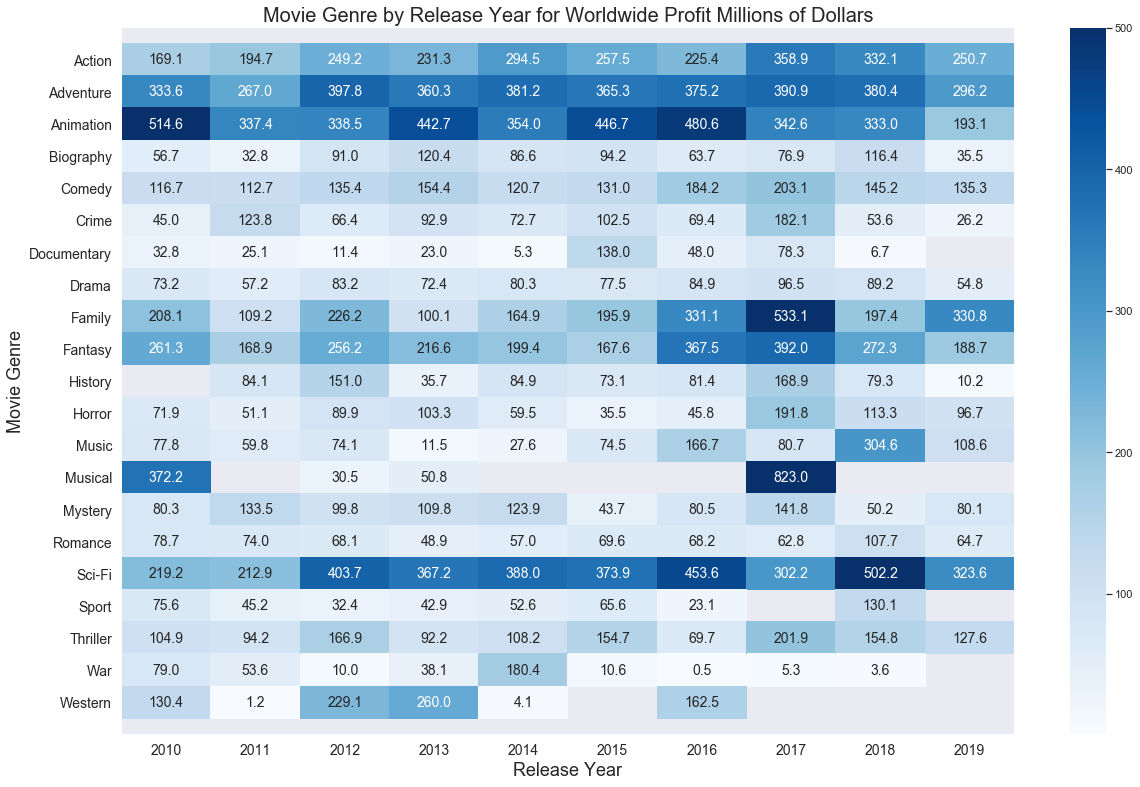

In [20]:
plt.subplots(figsize=(20,13))
plt.title('Movie Genre by Release Year for Worldwide Profit Millions of Dollars', fontsize = 20)
h_map = sns.heatmap(df_hmap, cmap="Blues", annot=True, annot_kws={"size": 14}, fmt=".1f", vmax=500)
h_map.set_xticklabels(h_map.get_xmajorticklabels(), fontsize = 14)
h_map.set_yticklabels(h_map.get_ymajorticklabels(), fontsize = 14)
bottom, top = h_map.get_ylim()
h_map.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Release Year', fontsize = 18)
plt.ylabel('Movie Genre', fontsize = 18)
sns.set(font_scale = 1.4)
plt.savefig('./plot_images/heatmap_genre.png')
plt.show()

In [21]:
df_budget_genre_studio.head()

,Unnamed: 0,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,domestic_profit,worldwide_profit,...,worldwide_roi,tconst,primary_title,original_title,start_year,runtime_minutes,genres,genre_list,title,studio
0,0,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,-169536125.0,6.350639e+08,...,2.546673,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy","['Action', 'Adventure', 'Fantasy']",Pirates of the Caribbean: On Stranger Tides,BV
1,1,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,128405868.0,1.072414e+09,...,4.243841,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi","['Action', 'Adventure', 'Sci-Fi']",Avengers: Age of Ultron,BV
2,2,7,"Apr 27, 2018",Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,2018,378815482.0,1.748134e+09,...,6.827114,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi","['Action', 'Adventure', 'Sci-Fi']",Avengers: Infinity War,BV
3,3,9,"Nov 17, 2017",Justice League,300000000.0,229024295.0,6.559452e+08,2017,-70975705.0,3.559452e+08,...,2.186484,tt0974015,Justice League,Justice League,2017,120.0,"Action,Adventure,Fantasy","['Action', 'Adventure', 'Fantasy']",Justice League,WB
4,4,10,"Nov 6, 2015",Spectre,300000000.0,200074175.0,8.796209e+08,2015,-99925825.0,5.796209e+08,...,2.932070,tt2379713,Spectre,Spectre,2015,148.0,"Action,Adventure,Thriller","['Action', 'Adventure', 'Thriller']",Spectre,Sony


In [22]:
# This cell preps a main dataframe to generate bar charts used to display the top studios by top genre and worldwide profit
df_budget_genre_studio['genre'] = df_budget_genre_studio['genres'].str.split(",")
df_studio = df_budget_genre_studio.explode('genre')

df_studio.drop(columns = ['Unnamed: 0', 'id', 'release_date', 'production_budget', 'domestic_gross', \
                         'worldwide_gross', 'primary_title', 'domestic_profit', 'original_title', 'start_year', \
                         'runtime_minutes', 'genres', 'genre_list', 'movie', 'tconst', 'title', 'domestic_roi'], inplace = True)
df_studio = df_studio[df_studio['worldwide_profit'] > 0.1]
df_studio['worldwide_profit'] = df_studio['worldwide_profit'] / 1000000
df_studio['worldwide_profit'] = df_studio['worldwide_profit'].round(1)
df_studio["studio"]= df_studio["studio"].replace(["P/DW", "BV", "WB (NL)", "LGF", "Sum.", "Uni.", "UTV", "WB", "Par."], \
                                                 ["DreamWorks", " Marvel Studios", "New Line Cinema", "Lions Gate Films", \
                                                  "Summit Entertainment", "Universal Pictures", "UTV Motion Pictures", "Warner Bros", "Paramount"])
df_studio = df_studio.groupby(['genre', 'studio']).mean()
df_studio.drop(['Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Music', 'Musical', \
                'Mystery', 'Romance', 'History', 'Horror', 'Sport', 'Thriller', 'War', 'Western'], inplace = True)


In [23]:
df_studio

year  worldwide_profit  worldwide_roi
genre  studio                                                          
Action  Marvel Studios     2014.875000        592.825000       3.960342
       BH Tilt             2018.000000         13.600000       5.517762
       CBS                 2010.500000         22.800000       1.643891
       DreamWorks          2010.833333        425.383333       3.676041
       EC                  2015.000000         47.700000       3.168113
...                                ...               ...            ...
Sci-Fi TriS                2013.000000        166.200000       2.384934
       Universal Pictures  2013.750000        319.683333       6.645259
       W/Dim.              2012.000000         22.850000       6.609512
       Warner Bros         2014.461538        256.715385       2.676993
       Wein.               2014.000000         41.500000       2.661608

[110 rows x 3 columns]

In [24]:
# This cell creates sub dataframes from the main dataframe above by genre to make plotting easier
df_action = df_studio.copy()
df_action.drop(['Adventure', 'Animation', 'Fantasy', 'Sci-Fi'], inplace = True)
df_action.sort_values(by='worldwide_profit', ascending=False)
df_action = pd.pivot_table(data = df_action,
                    index ='studio',
                    values ='worldwide_profit',
                    columns ='genre')
df_action.sort_values('Action', ascending = False, inplace = True)
df_action = df_action.head()

df_adventure = df_studio.copy()
df_adventure.drop(['Action', 'Animation', 'Fantasy', 'Sci-Fi'], inplace = True)
df_adventure = pd.pivot_table(data = df_adventure,
                    index ='studio',
                    values ='worldwide_profit',
                    columns ='genre')
df_adventure.sort_values('Adventure', ascending = False, inplace = True)
df_adventure = df_adventure.head()

df_animation = df_studio.copy()
df_animation.drop(['Action', 'Adventure', 'Fantasy', 'Sci-Fi'], inplace = True)
df_animation = pd.pivot_table(data = df_animation,
                    index ='studio',
                    values ='worldwide_profit',
                    columns ='genre')
df_animation.sort_values('Animation', ascending = False, inplace = True)
df_animation = df_animation.head()

df_fantasy = df_studio.copy()
df_fantasy.drop(['Action', 'Adventure', 'Animation', 'Sci-Fi'], inplace = True)
df_fantasy = pd.pivot_table(data = df_fantasy,
                    index ='studio',
                    values ='worldwide_profit',
                    columns ='genre')
df_fantasy.sort_values('Fantasy', ascending = False, inplace = True)
df_fantasy = df_fantasy.head()

df_sci_fi = df_studio.copy()
df_sci_fi.drop(['Action', 'Adventure', 'Animation', 'Fantasy'], inplace = True)
df_sci_fi = pd.pivot_table(data = df_sci_fi,
                    index ='studio',
                    values ='worldwide_profit',
                    columns ='genre')
df_sci_fi.sort_values('Sci-Fi', ascending = False, inplace = True)
df_sci_fi = df_sci_fi.head()

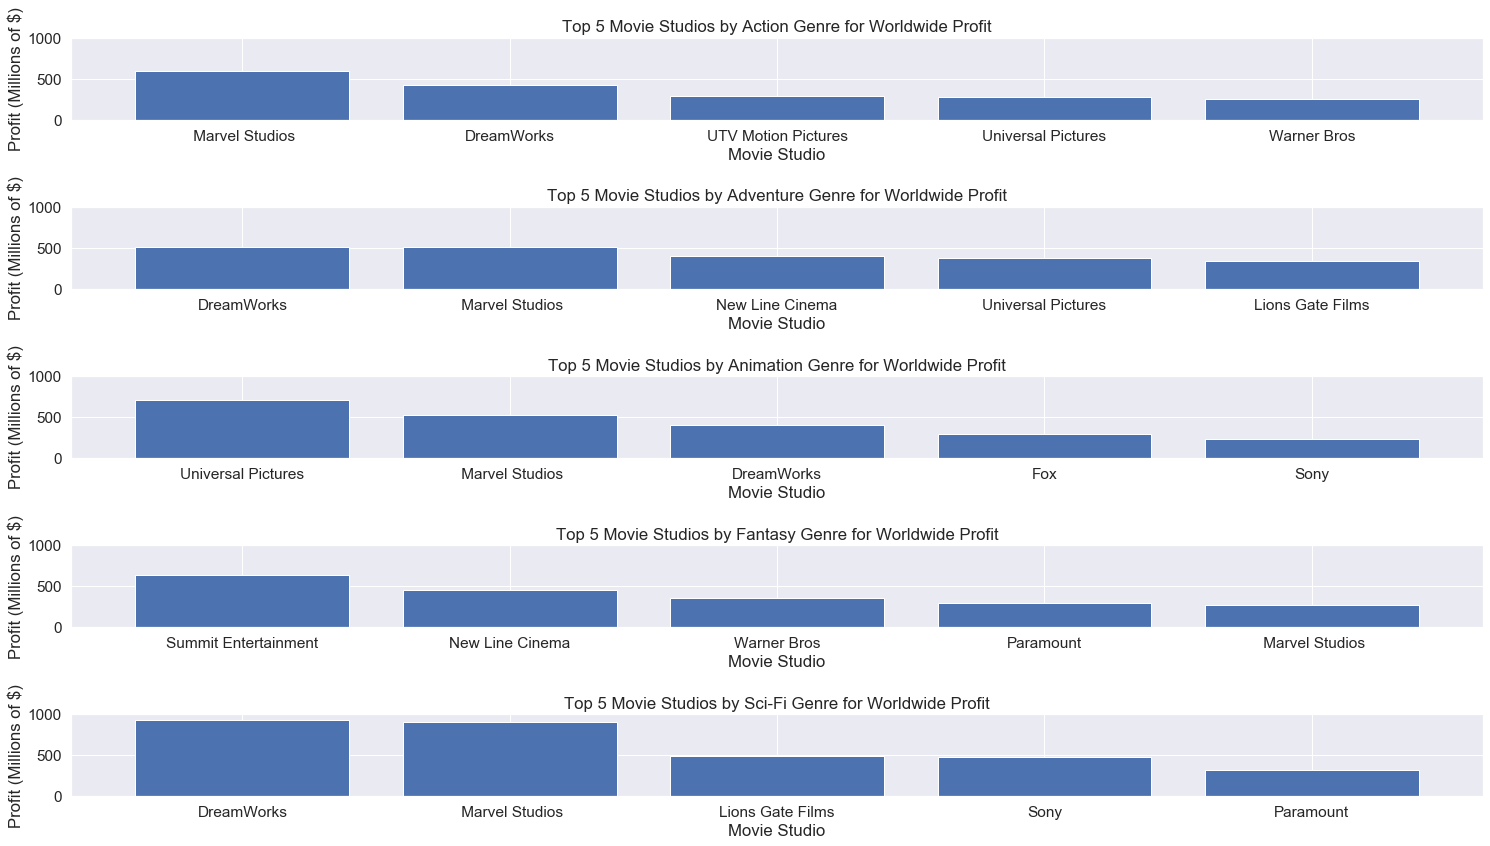

In [25]:
#Create figure obj
genre_bars_fig = plt.figure(figsize=(21, 12))

#Create Action subplot
action_bars = genre_bars_fig.add_subplot(511)

#Create Adventure subplot
adventure_bars = genre_bars_fig.add_subplot(512)

#Create Animation subplot
animation_bars = genre_bars_fig.add_subplot(513)

#Create Fantasy subplot
fantasy_bars = genre_bars_fig.add_subplot(514)

#Create Sci-Fi subplot
sci_fi_bars = genre_bars_fig.add_subplot(515)

#Plot action bars
action_bars.bar(x = df_action.index, height = df_action.Action)
action_bars.set_xlabel('Movie Studio')
action_bars.set_ylabel('Profit (Millions of $)')
action_bars.set_title('Top 5 Movie Studios by Action Genre for Worldwide Profit')
action_bars.set_ylim(top = 1000)

#Plot adventure bars
adventure_bars.bar(x = df_adventure.index, height = df_adventure.Adventure)
adventure_bars.set_xlabel('Movie Studio')
adventure_bars.set_ylabel('Profit (Millions of $)')
adventure_bars.set_title('Top 5 Movie Studios by Adventure Genre for Worldwide Profit')
adventure_bars.set_ylim(top = 1000)

#Plot animation bars
animation_bars.bar(x = df_animation.index, height = df_animation.Animation)
animation_bars.set_xlabel('Movie Studio')
animation_bars.set_ylabel('Profit (Millions of $)')
animation_bars.set_title('Top 5 Movie Studios by Animation Genre for Worldwide Profit')
animation_bars.set_ylim(top = 1000)

#Plot fantasy bars
fantasy_bars.bar(x = df_fantasy.index, height = df_fantasy.Fantasy)
fantasy_bars.set_xlabel('Movie Studio')
fantasy_bars.set_ylabel('Profit (Millions of $)')
fantasy_bars.set_title('Top 5 Movie Studios by Fantasy Genre for Worldwide Profit')
fantasy_bars.set_ylim(top = 1000)

#Plot sci-fi bars
sci_fi_bars.bar(x = df_sci_fi.index, height = df_sci_fi['Sci-Fi'])
sci_fi_bars.set_xlabel('Movie Studio')
sci_fi_bars.set_ylabel('Profit (Millions of $)')
sci_fi_bars.set_title('Top 5 Movie Studios by Sci-Fi Genre for Worldwide Profit')
sci_fi_bars.set_ylim(top = 1000)

genre_bars_fig.set_tight_layout(True)

genre_bars_fig.savefig('./plot_images/bar_chart_top_fives_studios.png')


In [26]:
df_genre.head()

,year,worldwide_profit,genre
0,2011,1045.7,Action
0,2011,1045.7,Adventure
0,2011,1045.7,Fantasy
1,2019,149.8,Action
1,2019,149.8,Adventure


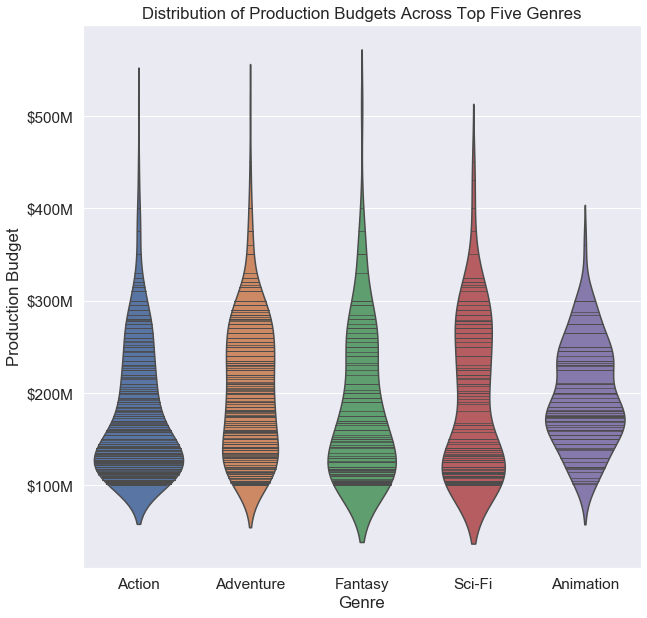

In [27]:
# Create top five genre DF (no studios)
budget_genre = budget_by_genre.explode('genre')


top_five = budget_genre[budget_genre.genre.isin(['Action', 'Adventure', 'Animation','Fantasy', 'Sci-Fi'])]


budget_genre.head()

fig = plt.figure(figsize=(10, 10))
violin = sns.violinplot(x="genre", y="production_budget", inner="stick", data=top_five)
violin.set_xlabel('Genre')
violin.set_ylabel('Production Budget')
violin.set_yticklabels(['0', '$100M', '$200M', '$300M', '$400M', '$500M'])
violin.set_title('Distribution of Production Budgets Across Top Five Genres')
plt.show()

fig.savefig('./plot_images/top_five_genres_budget_violinplot.png')

In [36]:
df = pd.read_pickle('./cleaned_data/budget_by_genre.pkl')
df = df.explode('genre_list')
df.rename(columns={'worldwide_roi': 'Worldwide ROI', 'genre_list': 'Genre',
                  'worldwide_profit':'Worldwide Profit'}, inplace=True)
df_top_five = df[df.Genre.isin(['Action', 'Adventure', 'Animation','Fantasy', 'Sci-Fi'])]
df_top_five.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,domestic_profit,Worldwide Profit,domestic_roi,Worldwide ROI,tconst,primary_title,original_title,start_year,runtime_minutes,genres,Genre
0,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,-169536125.0,635063875.0,0.587101,2.546673,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy",Action
0,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,-169536125.0,635063875.0,0.587101,2.546673,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy",Adventure
0,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,-169536125.0,635063875.0,0.587101,2.546673,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy",Fantasy
1,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019,-307237650.0,-200237650.0,0.122178,0.427892,tt6565702,Dark Phoenix,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",Action
1,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019,-307237650.0,-200237650.0,0.122178,0.427892,tt6565702,Dark Phoenix,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",Adventure


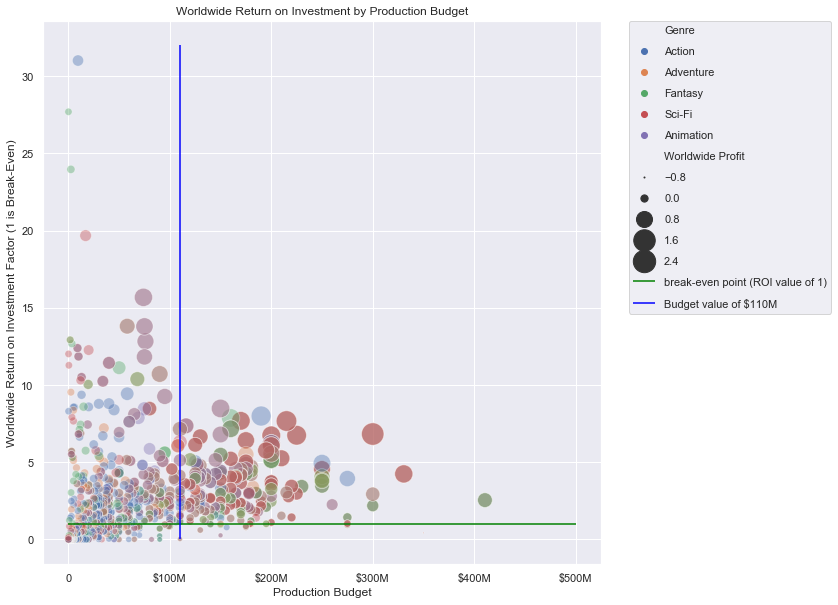

In [43]:
fig1 = plt.figure(figsize=(10,10))
#g = fig1.add_subplot(111)
sns.set(style='darkgrid')
g = sns.scatterplot(x='production_budget', y='Worldwide ROI', hue='Genre', size='Worldwide Profit',
                    sizes=(1, 500), data=df_top_five, alpha = 0.4)
#g.set_xlim(datetime.date(2009, 1, 1), datetime.date(2020, 6, 1))
g.hlines(y=1, xmin=0, xmax=500000000, color='green', label='break-even point (ROI value of 1)')
g.vlines(x=110000000, ymin=0, ymax=32, color='blue', label='Budget value of $110M')
g.set_ylabel('Worldwide Return on Investment Factor (1 is Break-Even)')
g.set_title('Worldwide Return on Investment by Production Budget')
g.set_xticklabels(['0', '0', '$100M', '$200M', '$300M', '$400M', '$500M'])
g.set_xlabel('Production Budget')
g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labelspacing = 1.0)
#exploded_df.plot(kind='scatter', x='production_budget', y='worldwide_profit', color='genre_list')
#g.set_xscale("log")
fig1.savefig('./plot_images/bad_bubble.png', bbox_inches='tight')

---

<h1>Conclusions

• Providing content in the Action, Adventure, Animation, Fantasy, or Sci-Fi genres will be most profitable.

• Acquiring or partnering with a top studio (Marvel Studios, DreamWorks, Universal) will maximize returns.

• Though there is possibility of higher return on investment at lower spend levels, there is also much higher rate of net loss.

• Recommend spend level of around 110M or higher as there is low likelihood of losing investment, and larger net profits despite the lower ROI value.